In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import dotenv
from sqlalchemy import create_engine, text

dotenv.load_dotenv()

True

In [2]:
df = pd.read_csv("data/data.csv")
df

,crm_contact_functietitel,crm_contact_voka_medewerker,crm_persoon_mail_thema_duurzaamheid,crm_persoon_mail_thema_financieel_fiscaal,crm_persoon_mail_thema_innovatie,crm_persoon_mail_thema_internationaal_ondernemen,crm_persoon_mail_thema_mobiliteit,crm_persoon_mail_thema_omgeving,crm_persoon_mail_thema_sales_marketing_communicatie,crm_persoon_mail_thema_strategie_en_algemeen_management,...,afspraak_account_subthema_Zelfkennis,afspraak_account_infosessie,afspraak_account_opleiding,afspraak_account_netwerkevenement,afspraak_account_project,afspraak_account_projectgebonden,afspraak_account_campagne,crm_campagne_type_campagne,crm_campagne_soort_campagne,attended
0,Business Relations + Development,0.0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netwerkevenement,Offline,1
1,Zaakv. vennootsch. beperkte aansprakel.,0.0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netwerkevenement,Offline,0
2,Zaakv. vennootsch. beperkte aansprakel.,0.0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netwerkevenement,Offline,0
3,Algemeen Directeur,0.0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netwerkevenement,Offline,1
4,NaN,0.0,Nee,Ja,Nee,Nee,Nee,Nee,Ja,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netwerkevenement,Offline,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100014,Export Sales Manager,0.0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Project,Offline,0
100015,Zaakvoerder,0.0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Project,Offline,0
100016,Vakexpert bedrijfssoftware en bedrijfsprocessen,0.0,Nee,Nee,Nee,Nee,Nee,Nee,Nee,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Opleiding,Offline,0
100017,"Management-, communicatie- en marketingsupport",0.0,Ja,Nee,Ja,Nee,Nee,Nee,Ja,Nee,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Netwerkevenement,Offline,1


In [3]:
X_df, y_df = df.drop(columns=["attended"]), df["attended"]

X_df.shape, y_df.shape

((100019, 272), (100019,))

In [4]:
# Split the data into train and test sets
from sklearn.model_selection import train_test_split

X_train_df, X_test_df, y_train_df, y_test_df = train_test_split(
    X_df, y_df, test_size=0.1, random_state=42
)

X_val_df, X_test_df, y_val_df, y_test_df = train_test_split(
    X_test_df, y_test_df, test_size=0.25, random_state=42
)

X_train_df.shape, X_val_df.shape, X_test_df.shape

((90017, 272), (7501, 272), (2501, 272))

In [5]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import SimpleImputer

# Based on unique values, decide what to do with the columns
single_cols = []  # 1 unique value

df_objects = X_train_df.select_dtypes(include="object").columns

# Label encode the columns
label_encoder = LabelEncoder()
X_df_encoded = X_df.copy()
for col in df_objects:
    X_df_encoded[col] = label_encoder.fit_transform(X_df_encoded[col])
    X_train_df[col] = label_encoder.transform(X_train_df[col])
    X_val_df[col] = label_encoder.transform(X_val_df[col])
    X_test_df[col] = label_encoder.transform(X_test_df[col])

# Assert that all columns are numeric or float
assert X_train_df.select_dtypes(include="object").shape[1] == 0

imp = SimpleImputer(missing_values=np.nan, strategy="mean")
imp.fit(X_df_encoded)
X_train_df = imp.transform(X_train_df)
X_val_df = imp.transform(X_val_df)
X_test_df = imp.transform(X_test_df)

# Scale the data
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_df = scaler.fit_transform(X_train_df)
X_val_df = scaler.transform(X_val_df)
X_test_df = scaler.transform(X_test_df)

# Assert that there are no NaNs

# Save the scaler, label encoder and imputer
import pickle

with open(os.path.join(os.getenv("EPIC_3_SAVE_LOCATION"), "scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

with open(
    os.path.join(os.getenv("EPIC_3_SAVE_LOCATION"), "label_encoder.pkl"), "wb"
) as f:
    pickle.dump(label_encoder, f)

with open(os.path.join(os.getenv("EPIC_3_SAVE_LOCATION"), "imputer.pkl"), "wb") as f:
    pickle.dump(imp, f)

assert np.isnan(X_train_df).sum() == 0
X_train_df.shape, X_val_df.shape, X_test_df.shape, y_train_df.shape

((90017, 272), (7501, 272), (2501, 272), (90017,))

In [6]:
# Make sure there are no NaN values
assert np.isnan(X_train_df).any() == False
assert np.isnan(X_test_df).any() == False

In [7]:
# Create a model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.losses import CategoricalCrossentropy

model = Sequential()
model.add(layers.Dense(256, activation="relu", input_shape=(X_train_df.shape[1],)))
model.add(layers.Dense(128, activation="relu"))
model.add(layers.Dense(64, activation="relu"))
model.add(layers.Dense(32, activation="relu"))  
model.add(layers.Dense(1, activation="sigmoid"))

model.compile(optimizer="RMSProp", loss="binary_crossentropy", metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               69888     
                                                                 
 dense_1 (Dense)             (None, 128)               32896     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 113153 (442.00 KB)
Trainable params: 113153 (442.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [8]:
epochs = 100
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_accuracy",
    patience=int(epochs / 10),
    restore_best_weights=True,
)

hist = model.fit(
    X_train_df,
    y_train_df,
    epochs=epochs,
    batch_size=64,
    validation_data=(X_val_df, y_val_df),
    callbacks=[early_stopping],
)


Epoch 1/100
1407/1407 [==============================] - 4s 2ms/step - loss: 0.3593 - accuracy: 0.8464 - val_loss: 0.3486 - val_accuracy: 0.8510
Epoch 2/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3412 - accuracy: 0.8561 - val_loss: 0.3467 - val_accuracy: 0.8599
Epoch 3/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3339 - accuracy: 0.8615 - val_loss: 0.3511 - val_accuracy: 0.8479
Epoch 4/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3290 - accuracy: 0.8644 - val_loss: 0.3302 - val_accuracy: 0.8652
Epoch 5/100
1407/1407 [==============================] - 2s 2ms/step - loss: 0.3253 - accuracy: 0.8665 - val_loss: 0.3339 - val_accuracy: 0.8635
Epoch 6/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3225 - accuracy: 0.8677 - val_loss: 0.3308 - val_accuracy: 0.8708
Epoch 7/100
1407/1407 [==============================] - 3s 2ms/step - loss: 0.3207 - accuracy: 0.8693 - val_loss: 0.3317 - val_ac

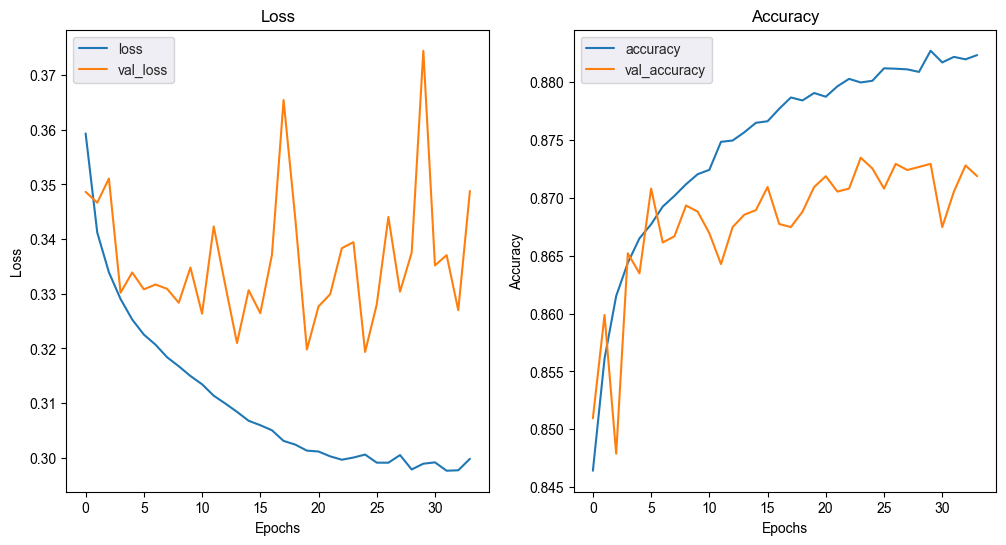

In [9]:
# Plot the loss
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.set_style("darkgrid")
sns.set_palette("Set2")

sns.lineplot(
    x=range(len(hist.history["loss"])), y=hist.history["loss"], label="loss", ax=ax[0]
)
sns.lineplot(
    x=range(len(hist.history["val_loss"])),
    y=hist.history["val_loss"],
    label="val_loss",
    ax=ax[0],
)

ax[0].set_title("Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")

sns.lineplot(
    x=range(len(hist.history["accuracy"])),
    y=hist.history["accuracy"],
    label="accuracy",
    ax=ax[1],
)
sns.lineplot(
    x=range(len(hist.history["val_accuracy"])),
    y=hist.history["val_accuracy"],
    label="val_accuracy",
    ax=ax[1],
)

ax[1].set_title("Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")

plt.show()

79/79 [==============================] - 0s 1ms/step
[[0.06565621]
 [0.0538142 ]
 [0.6517857 ]
 ...
 [0.01445094]
 [0.94619334]
 [0.72680676]]
[[0]
 [0]
 [1]
 ...
 [0]
 [1]
 [1]]
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1223
           1       0.88      0.87      0.88      1278

    accuracy                           0.87      2501
   macro avg       0.87      0.87      0.87      2501
weighted avg       0.87      0.87      0.87      2501



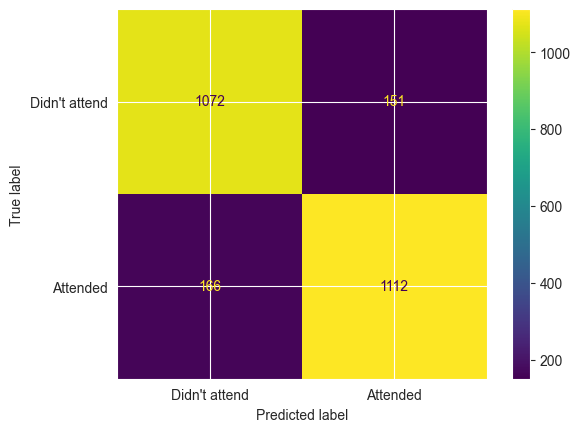

In [10]:
# Evaluate the model
model.evaluate(X_test_df, y_test_df)

# Create a confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import ConfusionMatrixDisplay

y_pred = model.predict(X_test_df)
print(y_pred)

# Convert the predictions to binary
y_pred = np.where(y_pred > 0.5, 1, 0)
print(y_pred)

# Classification report
print(classification_report(y_test_df, y_pred))


# display the confusion matrix
cm = confusion_matrix(y_test_df, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Didn't attend", "Attended"])
disp.plot()

In [11]:
# Save the model
model.save("data/model.keras")
print("Saved model to disk")

Saved model to disk
